# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。


In [1]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pwd

/content


In [3]:
# CPU!!! --gdrive
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/dl_p4_face_generation')
!pwd

/content/gdrive/My Drive/Colab Notebooks/dl_p4_face_generation


In [4]:
!ls

dlnd_face_generation.ipynb     helper.py
dlnd_face_generation-zh.ipynb  problem_unittests.py


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

# '/device:GPU:0' 
#  GPU is working

'/device:GPU:0'

In [0]:
!pip install matplotlib==2.0.2

In [0]:
import helper

### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [0]:
!pip install matplotlib==2.0.2
import helper

In [6]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

     |████████████████████████████████| 14.6MB 7.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalled matplotlib-3.0.3


Extracting mnist: 100%|██████████| 60.0k/60.0k [00:09<00:00, 6.46kFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

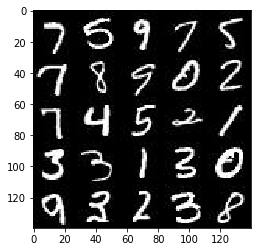

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

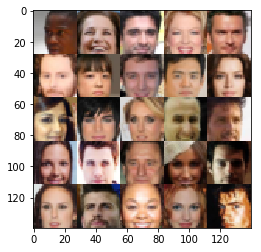

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    INPUTS:
      image_width: The input image width
      image_height: The input image height
      image_channels: The number of image channels
      z_dim: The dimension of Z
    OUTPUT:
      Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, None, name = 'learning_rate')

    return img, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [75]:
def discriminator(images, reuse=False, alpha = 0.2, training = True):
    """
    Create the discriminator network
    INPUTS:
      image: Tensor of input image(s)
      reuse: Boolean if the weights should be reused
      alpha: A parameter to build 'Leaky Relu' function
      training: Boolean if generator is being used for training
    OUTPUT:
      Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
      
      # Input layer is 28*28*3
      x1 = tf.layers.conv2d(images, 128, 5, strides = 2, padding='same')
      x1 = tf.maximum(alpha * x1, x1)
      # 14*14*128
      
      x2 = tf.layers.conv2d(x1, 256, 5, strides = 2, padding = 'same')
      x2 = tf.layers.batch_normalization(x2, training = training)
      x2 = tf.maximum(alpha * x2, x2)
      # 7*7*256
      
      x3 = tf.layers.conv2d(x2, 512, 5, strides = 1, padding = 'same')
      x3 = tf.layers.batch_normalization(x3, training = training)
      x3 = tf.maximum(alpha * x3, x3)
      # 7*7*512
      
      # Flatten it
      x4 = tf.reshape(x3, (-1, 7*7*512))
      logits = tf.layers.dense(x4, 1)
      output = tf.sigmoid(logits)
      

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [26]:
def generator(z, out_channel_dim, training=True, alpha = 0.2):
    """
    Create the generator network
    INPUTS:
      z: Input z
      out_channel_dim: The number of channels in the output image
      training: Boolean if generator is being used for training
      alpha: A parameter to build 'Leaky Relu' function
    OUTPUT:
      The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not training):
      
      # First fully connected layer
      x1 = tf.layers.dense(z, 7*7*512)
      # Reshape it to start the convolutional stack
      x1 = tf.reshape(x1, (-1, 7, 7, 512))
      x1 = tf.layers.batch_normalization(x1, training = training)
      x1 = tf.maximum(alpha * x1, x1) # Leaky Relu
      # 7*7*512 now
      
      x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
      x2 = tf.layers.batch_normalization(x2, training = training)
      x2 = tf.maximum(alpha * x2, x2)
      # 14*14*256 now
      
      x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding ='same')
      x3 = tf.layers.batch_normalization(x3, training = training)
      x3 = tf.maximum(alpha * x3, x3)
      # 28*28*128 now
      
      # output layer
      logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding = 'same')
      # 28*28*out_channel_dim now
      
      output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2):
    """
    Get the loss for the discriminator and generator
    INPUTS:
      input_real: Images from the real dataset
      input_z: Z input
      out_channel_dim: The number of channels in the output image
      alpha: A parameter in 'Leaky Relu' function in the function Generator / Discriminator
    OUTPUT:
      A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha = alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, alpha = alpha, reuse=True)
    
    g_loss      = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                labels = tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [32]:
def model_opt(d_loss, g_loss, lr, beta1):
    """
    Get optimization operations
    INPUTS:
      d_loss: Discriminator loss Tensor
      g_loss: Generator loss Tensor
      lr: Learning Rate Placeholder
      beta1: The exponential decay rate for the 1st moment in the optimizer
    OUTPUT:
      A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimise
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      g_train_opt = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(g_loss, var_list = g_vars)
      d_train_opt = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [0]:
#  A function for displaying generated images.
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    INPUTS: 
      epoch_count: Number of epochs
      batch_size: Batch Size
      z_dim: Z dimension
      learning_rate: Learning Rate
      beta1: The exponential decay rate for the 1st moment in the optimizer
      get_batches: Function to get batches
      data_shape: Shape of the data
      data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    # TODO: Train Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
          
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, 
                                                 input_z:    batch_z,
                                                 lr:         learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images,
                                                 input_z:    batch_z,
                                                 lr:         learning_rate})
                
                # At the end of each epoch, get the losses and print them out
                if steps % print_every == 0:
                  # Calculate losses
                  train_loss_d = d_loss.eval({input_z: batch_z,
                                              input_real: batch_images})
                  train_loss_g = g_loss.eval({input_z: batch_z})
                  
                  # Print losses
                  print("Epoch {}/{}  ||".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}  ||".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                  # Save losses to view after training
                  losses.append((train_loss_d, train_loss_g))
                  
                if steps % show_every == 0:
                  show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
  

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2  || Discriminator Loss: 2.1149  || Generator Loss: 0.1927
Epoch 1/2  || Discriminator Loss: 0.9173  || Generator Loss: 1.0584
Epoch 1/2  || Discriminator Loss: 3.0142  || Generator Loss: 6.7621
Epoch 1/2  || Discriminator Loss: 1.9985  || Generator Loss: 0.3129
Epoch 1/2  || Discriminator Loss: 0.6891  || Generator Loss: 2.1523
Epoch 1/2  || Discriminator Loss: 0.6483  || Generator Loss: 1.5041
Epoch 1/2  || Discriminator Loss: 0.5741  || Generator Loss: 1.2693
Epoch 1/2  || Discriminator Loss: 0.5611  || Generator Loss: 1.2112
Epoch 1/2  || Discriminator Loss: 0.4491  || Generator Loss: 1.3774
Epoch 1/2  || Discriminator Loss: 0.3014  || Generator Loss: 1.8456


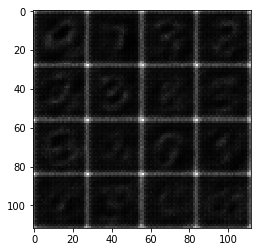

Epoch 1/2  || Discriminator Loss: 0.2397  || Generator Loss: 2.7315
Epoch 1/2  || Discriminator Loss: 0.1899  || Generator Loss: 2.3660
Epoch 1/2  || Discriminator Loss: 0.1298  || Generator Loss: 2.9095
Epoch 1/2  || Discriminator Loss: 0.1243  || Generator Loss: 2.7686
Epoch 1/2  || Discriminator Loss: 0.0924  || Generator Loss: 3.1608
Epoch 1/2  || Discriminator Loss: 0.0990  || Generator Loss: 2.9932
Epoch 1/2  || Discriminator Loss: 0.0642  || Generator Loss: 5.0631
Epoch 1/2  || Discriminator Loss: 0.0241  || Generator Loss: 6.6427
Epoch 1/2  || Discriminator Loss: 0.0388  || Generator Loss: 4.1850
Epoch 1/2  || Discriminator Loss: 0.0290  || Generator Loss: 4.5780


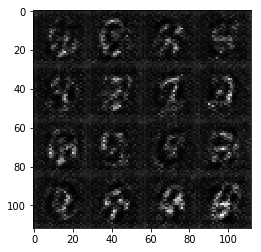

Epoch 1/2  || Discriminator Loss: 0.0168  || Generator Loss: 4.7950
Epoch 1/2  || Discriminator Loss: 0.1130  || Generator Loss: 2.4722
Epoch 1/2  || Discriminator Loss: 9.9185  || Generator Loss: 0.0007
Epoch 2/2  || Discriminator Loss: 0.0852  || Generator Loss: 6.8273
Epoch 2/2  || Discriminator Loss: 0.0908  || Generator Loss: 3.3847
Epoch 2/2  || Discriminator Loss: 0.0285  || Generator Loss: 4.4187
Epoch 2/2  || Discriminator Loss: 0.0479  || Generator Loss: 3.4268
Epoch 2/2  || Discriminator Loss: 0.0187  || Generator Loss: 6.4643
Epoch 2/2  || Discriminator Loss: 0.0873  || Generator Loss: 3.5099
Epoch 2/2  || Discriminator Loss: 0.1897  || Generator Loss: 7.9598


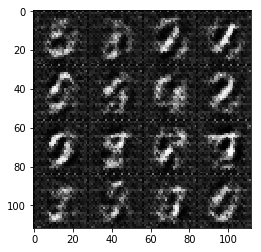

Epoch 2/2  || Discriminator Loss: 0.1907  || Generator Loss: 12.3990
Epoch 2/2  || Discriminator Loss: 0.0744  || Generator Loss: 3.6100
Epoch 2/2  || Discriminator Loss: 1.9750  || Generator Loss: 0.3399
Epoch 2/2  || Discriminator Loss: 1.8329  || Generator Loss: 9.6994
Epoch 2/2  || Discriminator Loss: 0.0728  || Generator Loss: 3.8445
Epoch 2/2  || Discriminator Loss: 0.3640  || Generator Loss: 8.2815
Epoch 2/2  || Discriminator Loss: 0.2179  || Generator Loss: 4.6619
Epoch 2/2  || Discriminator Loss: 0.1840  || Generator Loss: 2.2698
Epoch 2/2  || Discriminator Loss: 1.0497  || Generator Loss: 0.5420
Epoch 2/2  || Discriminator Loss: 0.0525  || Generator Loss: 4.4499


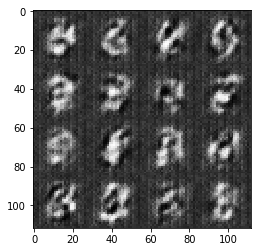

Epoch 2/2  || Discriminator Loss: 0.4068  || Generator Loss: 1.3831
Epoch 2/2  || Discriminator Loss: 0.0136  || Generator Loss: 8.8239
Epoch 2/2  || Discriminator Loss: 0.8133  || Generator Loss: 0.7886
Epoch 2/2  || Discriminator Loss: 0.3635  || Generator Loss: 1.5745
Epoch 2/2  || Discriminator Loss: 0.0285  || Generator Loss: 5.2200
Epoch 2/2  || Discriminator Loss: 0.0485  || Generator Loss: 6.3941


In [77]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1  || Discriminator Loss: 0.3859  || Generator Loss: 1.9219
Epoch 1/1  || Discriminator Loss: 0.3524  || Generator Loss: 1.9915
Epoch 1/1  || Discriminator Loss: 0.1902  || Generator Loss: 2.2079
Epoch 1/1  || Discriminator Loss: 0.2158  || Generator Loss: 6.9377
Epoch 1/1  || Discriminator Loss: 0.3557  || Generator Loss: 2.1193
Epoch 1/1  || Discriminator Loss: 0.1959  || Generator Loss: 2.5301
Epoch 1/1  || Discriminator Loss: 0.2286  || Generator Loss: 2.2268
Epoch 1/1  || Discriminator Loss: 0.1505  || Generator Loss: 2.7207
Epoch 1/1  || Discriminator Loss: 0.0922  || Generator Loss: 3.7747
Epoch 1/1  || Discriminator Loss: 0.0422  || Generator Loss: 4.8958


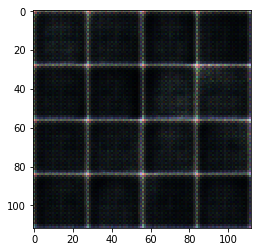

Epoch 1/1  || Discriminator Loss: 0.1365  || Generator Loss: 2.8389
Epoch 1/1  || Discriminator Loss: 1.0006  || Generator Loss: 0.7801
Epoch 1/1  || Discriminator Loss: 0.1832  || Generator Loss: 2.5937
Epoch 1/1  || Discriminator Loss: 0.0480  || Generator Loss: 6.2407
Epoch 1/1  || Discriminator Loss: 0.0146  || Generator Loss: 5.0367
Epoch 1/1  || Discriminator Loss: 2.0010  || Generator Loss: 0.5118
Epoch 1/1  || Discriminator Loss: 0.0384  || Generator Loss: 6.7262
Epoch 1/1  || Discriminator Loss: 0.2519  || Generator Loss: 3.0662
Epoch 1/1  || Discriminator Loss: 0.0279  || Generator Loss: 9.8700
Epoch 1/1  || Discriminator Loss: 0.0174  || Generator Loss: 8.2265


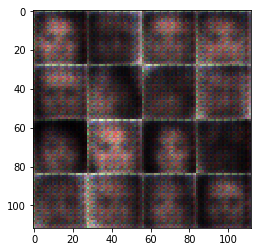

Epoch 1/1  || Discriminator Loss: 1.4486  || Generator Loss: 14.7045
Epoch 1/1  || Discriminator Loss: 0.0768  || Generator Loss: 3.2725
Epoch 1/1  || Discriminator Loss: 0.0127  || Generator Loss: 13.8403
Epoch 1/1  || Discriminator Loss: 0.1719  || Generator Loss: 3.3065
Epoch 1/1  || Discriminator Loss: 0.1769  || Generator Loss: 3.8165
Epoch 1/1  || Discriminator Loss: 0.2638  || Generator Loss: 2.4615
Epoch 1/1  || Discriminator Loss: 0.0118  || Generator Loss: 8.8695
Epoch 1/1  || Discriminator Loss: 0.5805  || Generator Loss: 9.2376
Epoch 1/1  || Discriminator Loss: 0.2693  || Generator Loss: 5.3705
Epoch 1/1  || Discriminator Loss: 0.1133  || Generator Loss: 8.2113


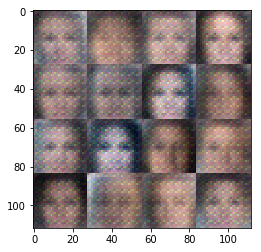

Epoch 1/1  || Discriminator Loss: 0.0465  || Generator Loss: 9.8409
Epoch 1/1  || Discriminator Loss: 0.0091  || Generator Loss: 8.7024
Epoch 1/1  || Discriminator Loss: 0.1362  || Generator Loss: 2.7808
Epoch 1/1  || Discriminator Loss: 1.7814  || Generator Loss: 0.2231
Epoch 1/1  || Discriminator Loss: 0.1614  || Generator Loss: 3.8839
Epoch 1/1  || Discriminator Loss: 1.5790  || Generator Loss: 0.3201
Epoch 1/1  || Discriminator Loss: 0.7373  || Generator Loss: 11.3846
Epoch 1/1  || Discriminator Loss: 0.0435  || Generator Loss: 8.3091
Epoch 1/1  || Discriminator Loss: 0.5887  || Generator Loss: 4.3435
Epoch 1/1  || Discriminator Loss: 0.4136  || Generator Loss: 8.7860


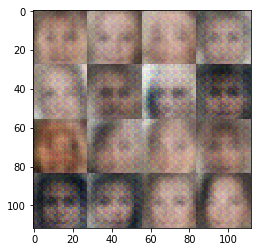

Epoch 1/1  || Discriminator Loss: 0.0834  || Generator Loss: 7.2962
Epoch 1/1  || Discriminator Loss: 0.0767  || Generator Loss: 3.1765
Epoch 1/1  || Discriminator Loss: 0.4650  || Generator Loss: 5.3493
Epoch 1/1  || Discriminator Loss: 0.0407  || Generator Loss: 6.2278
Epoch 1/1  || Discriminator Loss: 0.1622  || Generator Loss: 12.2070
Epoch 1/1  || Discriminator Loss: 0.2314  || Generator Loss: 7.1364
Epoch 1/1  || Discriminator Loss: 0.0806  || Generator Loss: 16.1507
Epoch 1/1  || Discriminator Loss: 0.1119  || Generator Loss: 7.3298
Epoch 1/1  || Discriminator Loss: 0.0423  || Generator Loss: 4.0015
Epoch 1/1  || Discriminator Loss: 4.8226  || Generator Loss: 0.0188


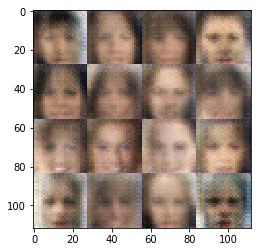

Epoch 1/1  || Discriminator Loss: 0.0335  || Generator Loss: 5.1660
Epoch 1/1  || Discriminator Loss: 0.4631  || Generator Loss: 1.2181
Epoch 1/1  || Discriminator Loss: 0.1597  || Generator Loss: 8.2783
Epoch 1/1  || Discriminator Loss: 0.0171  || Generator Loss: 5.0685
Epoch 1/1  || Discriminator Loss: 0.0118  || Generator Loss: 7.1730
Epoch 1/1  || Discriminator Loss: 0.2971  || Generator Loss: 1.5378
Epoch 1/1  || Discriminator Loss: 1.5024  || Generator Loss: 12.2255
Epoch 1/1  || Discriminator Loss: 0.2316  || Generator Loss: 10.9240
Epoch 1/1  || Discriminator Loss: 0.0778  || Generator Loss: 13.2468
Epoch 1/1  || Discriminator Loss: 0.0099  || Generator Loss: 16.3812


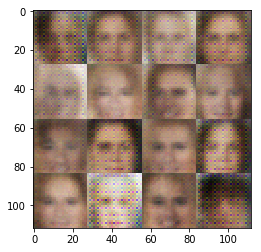

Epoch 1/1  || Discriminator Loss: 0.7169  || Generator Loss: 0.8018
Epoch 1/1  || Discriminator Loss: 1.2672  || Generator Loss: 0.4029
Epoch 1/1  || Discriminator Loss: 0.0062  || Generator Loss: 12.2996
Epoch 1/1  || Discriminator Loss: 0.1171  || Generator Loss: 2.5502
Epoch 1/1  || Discriminator Loss: 0.0126  || Generator Loss: 11.8896
Epoch 1/1  || Discriminator Loss: 0.0094  || Generator Loss: 10.2748
Epoch 1/1  || Discriminator Loss: 1.8522  || Generator Loss: 0.2361
Epoch 1/1  || Discriminator Loss: 0.0972  || Generator Loss: 12.2393
Epoch 1/1  || Discriminator Loss: 0.1631  || Generator Loss: 4.5435
Epoch 1/1  || Discriminator Loss: 0.3009  || Generator Loss: 9.1775


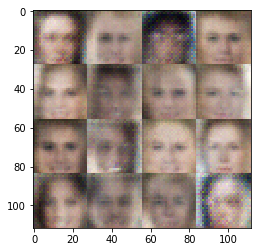

Epoch 1/1  || Discriminator Loss: 0.0219  || Generator Loss: 6.9348
Epoch 1/1  || Discriminator Loss: 0.0136  || Generator Loss: 6.2145
Epoch 1/1  || Discriminator Loss: 0.0458  || Generator Loss: 3.7308
Epoch 1/1  || Discriminator Loss: 0.0077  || Generator Loss: 10.5878
Epoch 1/1  || Discriminator Loss: 0.0055  || Generator Loss: 10.0383
Epoch 1/1  || Discriminator Loss: 0.0038  || Generator Loss: 15.1228
Epoch 1/1  || Discriminator Loss: 0.0479  || Generator Loss: 12.9061
Epoch 1/1  || Discriminator Loss: 0.1000  || Generator Loss: 2.7976
Epoch 1/1  || Discriminator Loss: 0.0072  || Generator Loss: 10.0194


In [78]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。

In [79]:
# Convert into HTML
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook dlnd_face_generation.ipynb to html',
 '[NbConvertApp] Writing 310774 bytes to dlnd_face_generation.html',
 '[NbConvertApp] Converting notebook dlnd_face_generation-zh.ipynb to html',
 "/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'application/vnd.colab-display-data+json'] is not able to be represented.",
 '  mimetypes=output.keys())',
 '[NbConvertApp] Writing 1082750 bytes to dlnd_face_generation-zh.html']